In [32]:
%pip install textblob
%pip install wordcloud
%pip install scikit-learn nltk


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [30]:
import praw
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ysuns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ysuns\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ysuns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ysuns\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Scrape the reddit comments.

In [11]:
# Authenticate with Reddit
reddit = praw.Reddit(
    client_id="EAEzPWfS3NsqvM3mgI_9KQ",
    client_secret="cmtE_-zKxIBzoVPW8nf4jEMefYpkOQ",
    user_agent="hyltda",
)

# Fetch comments from a subreddit
comments = []
subreddit = reddit.subreddit("electricvehicles")

for comment in subreddit.comments(limit=1000):  # Adjust limit as needed
    comments.append({
        "comment_id": comment.id,
        "author": comment.author.name if comment.author else None,
        "body": comment.body,
        "created_utc": comment.created_utc,
        "score": comment.score
    })

# Convert to DataFrame
comments_df = pd.DataFrame(comments)

# Save to CSV
comments_df.to_csv("reddit_ev_comments_praw.csv", index=False)
print("Saved comments to 'reddit_ev_comments_praw.csv'")

Saved comments to 'reddit_ev_comments_praw.csv'


### Preprocess the comments.

In [19]:
def preprocess_text(text):
    # Remove URLs and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

# Apply preprocessing to the comments
comments_df["cleaned_body"] = comments_df["body"].fillna("").apply(preprocess_text)

# Save preprocessed data for future use
comments_df.to_csv("reddit_ev_cleaned_comments.csv", index=False)


### Perform sentiment analysis.

In [22]:
# Download VADER data
nltk.download("vader_lexicon")

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment
comments_df["sentiment"] = comments_df["cleaned_body"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Add sentiment labels
def get_sentiment_label(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

comments_df["sentiment_label"] = comments_df["sentiment"].apply(get_sentiment_label)

# Preview the results
print(comments_df[["cleaned_body", "sentiment", "sentiment_label"]].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ysuns\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                        cleaned_body  sentiment  \
0                 making much profit per sale afford     0.4404   
1  fee would charged somebody iceing spot didnt g...    -0.2023   
2      obscene corruption broad daylight fuck people    -0.8074   
3  fast charger gas station near even 2 brand new...     0.5859   
4  yes usually much 40 mile upperwar technically ...     0.8834   

  sentiment_label  
0        Positive  
1        Negative  
2        Negative  
3        Positive  
4        Positive  


### Identify pain points.

In [24]:
negative_comments = comments_df[comments_df["sentiment_label"] == "Negative"]
print(negative_comments["cleaned_body"].head())



# Vectorize the negative comments
vectorizer = CountVectorizer(max_features=20, stop_words="english")
X = vectorizer.fit_transform(negative_comments["cleaned_body"])

# Get the top keywords
keywords = vectorizer.get_feature_names_out()
print("Top keywords in negative comments:", keywords)

1     fee would charged somebody iceing spot didnt g...
2         obscene corruption broad daylight fuck people
6     would prevent iceing spot ice obviously wouldn...
9                                         sam hell puma
17    chargepoint lock charger reservation cutting l...
Name: cleaned_body, dtype: object
Top keywords in negative comments: ['battery' 'car' 'charge' 'charger' 'charging' 'dont' 'ev' 'got' 'ive'
 'like' 'need' 'people' 'problem' 'range' 'tesla' 'think' 'time' 'truck'
 'want' 'year']


### Visualise findings

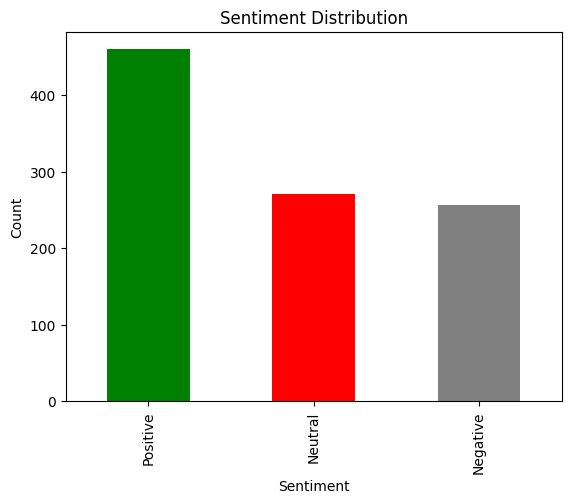

In [26]:
# Plot sentiment distribution
comments_df["sentiment_label"].value_counts().plot(kind="bar", color=["green", "red", "gray"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


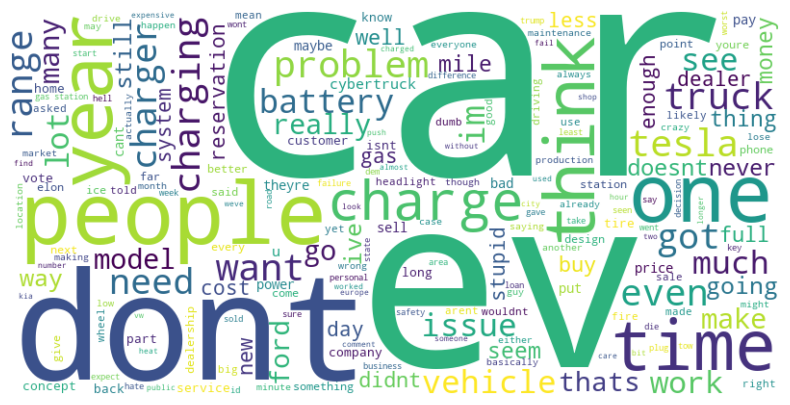

In [31]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(negative_comments["cleaned_body"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# Set up CountVectorizer to extract bigrams (2 consecutive words)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Apply the vectorizer to your cleaned comments data
bigrams = vectorizer.fit_transform(comments_df['cleaned_body'])

# Convert the bigrams to a DataFrame
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vectorizer.get_feature_names_out())

# Get the top 10 most common bigrams
top_bigrams = bigram_df.sum().sort_values(ascending=False).head(10)
print(top_bigrams)







# Set up CountVectorizer to extract trigrams (3 consecutive words)
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Apply the vectorizer to your cleaned comments data
trigrams = vectorizer.fit_transform(comments_df['cleaned_body'])

# Convert the trigrams to a DataFrame
trigram_df = pd.DataFrame(trigrams.toarray(), columns=vectorizer.get_feature_names_out())

# Get the top 10 most common trigrams
top_trigrams = trigram_df.sum().sort_values(ascending=False).head(10)
print(top_trigrams)

gas station      27
steel rim        15
dont want        15
alloy wheel      14
steel wheel      13
lot people       11
fast charging    10
ev truck         10
dont think        9
gas car           9
dtype: int64
best selling ev                    5
dc fast charging                   4
bait uncivil behavior              4
attack attempt bait                4
constructive permit personal       4
attempt bait uncivil               4
contribution civil constructive    4
civil constructive permit          4
permit personal attack             4
personal attack attempt            4
dtype: int64


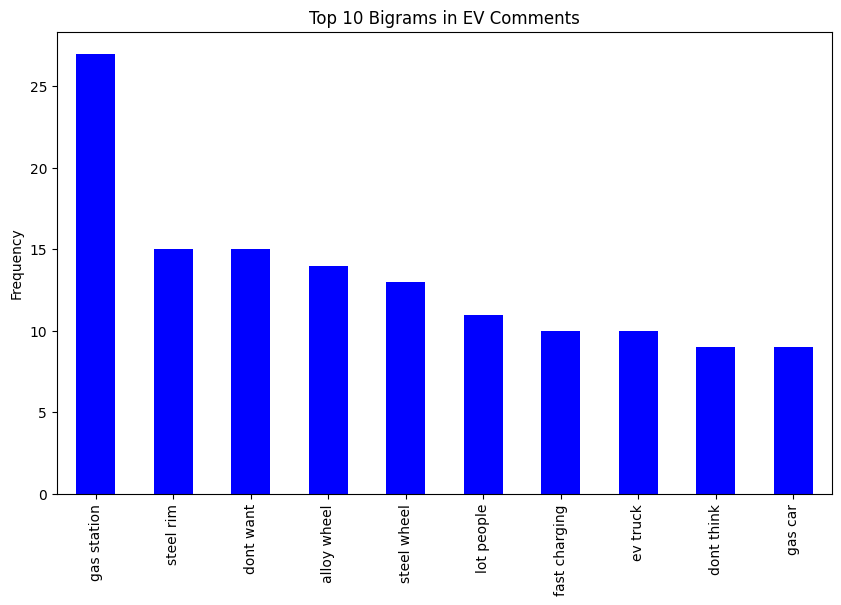

In [34]:
top_bigrams.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title("Top 10 Bigrams in EV Comments")
plt.ylabel("Frequency")
plt.show()


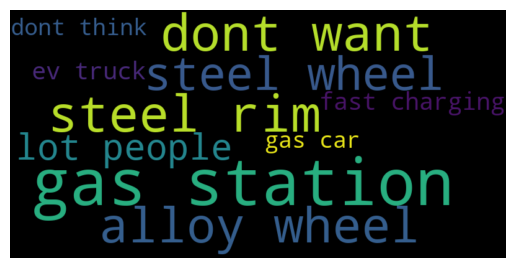

In [35]:
# rate a word cloud for the bigrams
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(top_bigrams)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
